# Uniaxial tension example

---

*Why is quantifying uncertainty important?* This notebook illustrates one answer: Designing safety-critical components in the presence of material and load condition variability. The presence of uncertainty can lead to unsafe designs. Rigorously quantifying the uncertainty can enable design with a known level of safety.

In [1]:
import grama as gr
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import bisect

## Deterministic Design

Suppose we were tasked with designing a simple structure: a cable to hold up an elevator. If the material has strength $U$, cross-sectional area $A$, and applied load $F$, its *limit state function* is given by

$$g_{\text{tension}} = U - F/A.$$

The structure survives its loading conditions when $g_{\text{tension}} > 0$, and fails if $g_{\text{tension}} \leq 0$. We can encode this physical model in `py_grama` with the following code.

In [2]:
def limit_state(x):
    U, F, A = x
    return U - F/A

md = gr.Model() >> \
    gr.cp_function(
        fun=limit_state,
        var=["U", "F", "A"],
        out=["g_tension"]
    ) >> \
    gr.cp_bounds(
        U=(500, 700),
        F=(50, 150),
        A=(0.2, 0.4)
    )
md.printpretty()

model: None

  inputs:
    var_det:
      A: [0.2, 0.4]
      U: [500, 700]
      F: [50, 150]
    var_rand:
    copula:
        None
  functions:
    limit_state: ['U', 'F', 'A'] -> ['g_tension']


We will formulate design as an optimization problem. For the structure, we want to use as little material as possible while ensuring the structure does not fail. Mathematically, a **deterministic design** problem is given as

$$\begin{aligned} \min_A\, & A \\ \text{s.t.}\, & g_{\text{tension}} > 0 \end{aligned}$$

Since this optimization problem is quite simple (it reduces to root finding), we can solve it with [bisection search](https://en.wikipedia.org/wiki/Bisection_method). We *arbitrarily select conditions for* $U, F$, and look for a sign change in $g_{\text{tension}}$ to "bracket" our target value of $0$.

In [3]:
df_design = pd.DataFrame(dict(U=[600] * 2, F=[100] * 2, A=[0.15, 0.20]))

gr.eval_df(md, df=df_design)

,U,F,A,g_tension
0,600,100,0.15,-66.666667
1,600,100,0.20,100.000000


The following convenience function will allow us to pass model results to `scipy.optimize.bisect`, which will carry out the root-finding.

In [4]:
def opt_deterministic(A):
    df_res = gr.eval_df(md, df=pd.DataFrame(dict(U=[600], F=[100], A=[A])))
    return df_res["g_tension"].values[0]

A_det = bisect(opt_deterministic, 0.15, 0.20)
A_det

0.16666666666715174

This is our optimal cross-sectional area.

However, remember that we had to *arbitrarily select conditions for* $U,F$! This should make any engineer *uncomfortable*, as we are adding no measure of safety to this design.

## Design Under Uncertainty

The traditional way to add safety to a design is to add a safety factor. However, imagine instead that we had some characterization of the uncertainty in our variables: Below we add distributions for $U, F$ which characterize the variability the structure will see in service.

Note that $U, F$ can be reasonably argued to be independent; thus we use an *independence copula* (`gr.cp_copula_independence`) to describe the dependence structure. If there were nonzero correlation between the inputs, we could instad use a *gaussian copula* (`gr.cp_copula_gaussian`) to introduce nonzero correlations.

In [7]:
md_uncertain = \
    md >> \
    gr.cp_marginals(
        U=dict(dist="norm", loc=600, scale=60),
        F=dict(dist="norm", loc=100, scale=10)
    ) >> \
    gr.cp_copula_independence()
md_uncertain.printpretty()

model: None

  inputs:
    var_det:
      A: [0.2, 0.4]
    var_rand:
      U: (+0) norm, {'loc': 600, 'scale': 60}
      F: (+0) norm, {'loc': 100, 'scale': 10}
    copula:
        Independence copula
  functions:
    limit_state: ['U', 'F', 'A'] -> ['g_tension']


Now the model has both *deterministic* (`var_det`) and *random* (`var_rand`) variables. The random variables are no longer guaranteed to take particular values; rather than single evaluations of the model, we should consider *Monte Carlo sampling* of the model. Let's inspect what happens with the design `A_det` we computed above.

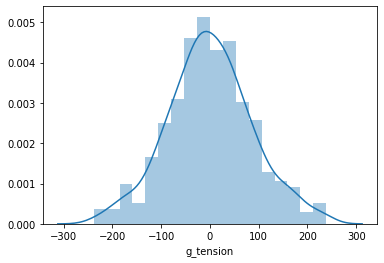

In [8]:
df_res = \
    md_uncertain >> \
    gr.ev_monte_carlo(
        n=500, 
        df_det=gr.df_make(A=A_det),
        seed=101
    ) 
sns.distplot(df_res["g_tension"])

Note that about half the distribution of `g_tension` values lie below zero---these correspond to failed structures, so the safety of this design is only about $50\%$! We could try to add a safety factor to bump up the safety. However, we can also directly *optimize* for a specified probability of failure. The following convenience function seeks a failure rate of $1\%$, which we again pass to `scipy.optimize.bisect`.

In [9]:
def opt_duu(A):
    df_mc = \
        md_uncertain >> \
        gr.ev_monte_carlo(
            n=500, 
            df_det=gr.df_make(A=A),
            seed=101
        )
    return np.quantile(df_mc["g_tension"], 0.01)

A_duu = bisect(opt_duu, 0.1, 0.3)
A_duu

0.23278769564203686

Let's inspect the results for the new design `A_duu`.

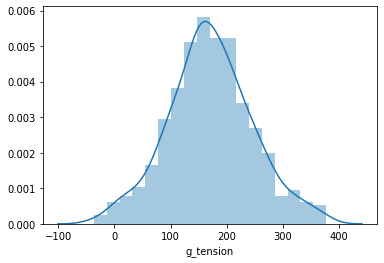

In [10]:
df_res_duu = \
    md_uncertain >> \
    gr.ev_monte_carlo(
        n=500, 
        df_det=gr.df_make(A=A_duu),
        seed=101
    )

sns.distplot(df_res_duu["g_tension"])

The new design has a far lower rate of failure! By explicitly quantifying the uncertainty, we can seek greater precision in structural safety.